In [20]:
# main_run.py
import os 
from Converted_python_scripts.rf_image_func import rf_image
from Converted_python_scripts.rf_fft_func import plot_group_ffts

# Path to your dataset
root_dir = "data/Raw_data"

# Example call
# Replace patient_id and image_num with valid ones in your dataset
#rf_image(patient_id=8, image_num=1, root_dir=root_dir)
csv_file = os.path.join("csv", "patient_eGFR_at_pocus_2025_Jul_polynomial_estimation.csv")


P8_PTONR_01_May_31-23-REB16236-008
data/Raw_data/P8_PTONR_01_May_31-23-REB16236-008/P8_Image_1/P8_PTONR_01_Image_1_rf.raw
hinfo 2
Data shape: (15, 1424, 144)


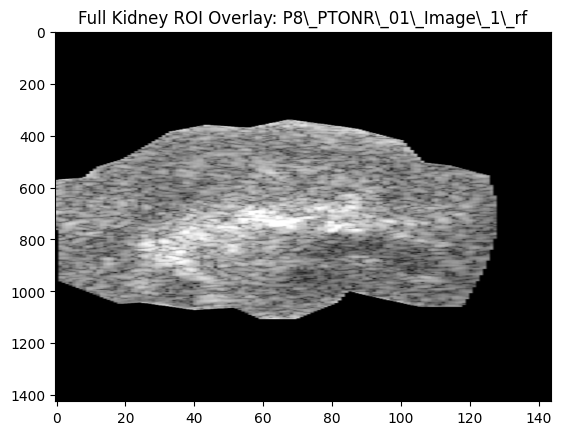

In [23]:
rf_image(patient_id = 8, image_num=1, root_dir=root_dir)

In [24]:
import sys, os
import re
from pathlib import Path
import platform

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

from scipy.signal import hilbert, get_window, welch, savgol_filter, medfilt
from scipy.fft import fft, fftfreq, fftshift, ifft, ifftshift
from scipy.io import loadmat, savemat

import yaml

import ipywidgets as widgets
from ipywidgets import interact

# read rf data
def read_rf(filename):
    hdr_info = ('id', 'frames', 'lines', 'samples', 'samplesize')
    hdr, timestamps, data = {}, None, None
    with open(filename, 'rb') as raw_bytes:
        # read 4 bytes header 
        for info in hdr_info:
            hdr[info] = int.from_bytes(raw_bytes.read(4), byteorder='little')
        # read timestamps and data
        timestamps = np.zeros(hdr['frames'], dtype='int64')
        sz = hdr['lines'] * hdr['samples'] * hdr['samplesize']
        data = np.zeros((hdr['lines'], hdr['samples'], hdr['frames']), dtype='int16')
        for frame in range(hdr['frames']):
            # read 8 bytes of timestamp
            timestamps[frame] = int.from_bytes(raw_bytes.read(8), byteorder='little')
            # read each frame
            data[:, :, frame] = np.frombuffer(raw_bytes.read(sz), dtype='int16').reshape([hdr['lines'], hdr['samples']])
    data =np.swapaxes(data,0,1)        
    print('Loaded {d[2]} raw frames of size, {d[0]} x {d[1]} (sampels x lines)'.format(d=data.shape))
    return hdr, timestamps, data

# read env data
def read_env(filename):
    hdr_info = ('id', 'frames', 'lines', 'samples', 'samplesize')
    hdr, timestamps, data = {}, None, None
    with open(filename, 'rb') as raw_bytes:
        # read 4 bytes header 
        for info in hdr_info:
            hdr[info] = int.from_bytes(raw_bytes.read(4), byteorder='little')
        # read timestamps and data
        timestamps = np.zeros(hdr['frames'], dtype='int64')
        sz = hdr['lines'] * hdr['samples'] * hdr['samplesize']
        data = np.zeros((hdr['lines'], hdr['samples'], hdr['frames']), dtype='uint8')
        for frame in range(hdr['frames']):
            # read 8 bytes of timestamp
            timestamps[frame] = int.from_bytes(raw_bytes.read(8), byteorder='little')
            # read each frame
            data[:, :, frame] = np.frombuffer(raw_bytes.read(sz), dtype='uint8').reshape([hdr['lines'], hdr['samples']])
    print('Loaded {d[2]} raw frames of size, {d[0]} x {d[1]} (lines x samples)'.format(d=data.shape))
    return hdr, timestamps, data

def rf_2_bmode(rf_data, dynamic_range=50, convert_to_8_bit=False):
    """
    Hisham Assi 2025 (hisham.assi@alumni.utoronto.ca)
    Apply gamma log compression (link below) while incorporating the db dynamic range commonin medical ultrasound 
    https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html

    Args:
    rf_data (np.ndarray): Input RF data
    dynamic_range (float): Dynamic range in dB
    convert_to_8_bit (bool): Whether to convert to 8-bit
        
    Returns:
        np.ndarray: B-mode image
    """
    # Envelope detection using Hilbert transform
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)
    M = np.max(envelope)
    A = 10**(dynamic_range/20) - 1
    bmode = np.log10(1 + A * (envelope/M))/np.log10(1+A)

    # Convert to 8-bit grayscale
    if convert_to_8_bit:
        bmode = (255 * bmode).astype(np.uint8) 
    
    return bmode

#Log compression from k-wave
def rf_to_bomode_gamma(rf_data, gamma=1, normalise=1):
    """
    Hisham Assi 2025
    """
    # 1. Envelope detection using Hilbert transform
    def envelope_detection(signal, axis=0):
        return np.abs(hilbert(signal, axis=0))
    # 2. gamma Log compression
    def gamma_log_compress(signal, gamma=1, normalise=1):
        """
        Hisham Assi 2025
        Apply gamma log compression to the input signal:
        https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html
        
        The larger the gamma, the larger the resulting compression
        This function is similar to k-wave's logCompression MATLAB function
        """
        mx = np.max(signal)
        if normalise == 0: # No normalisation
            return np.log10(1 + gamma * signal) 
        elif normalise == 1: # Normalise to [0, 1]
            return np.log10(1 + gamma * (signal / mx)) / np.log10(1 + gamma)
        elif normalise == 2: # Normalise to [0, mx]
            return mx * (np.log10(1 + gamma * (signal / mx)) / np.log10(1 + gamma))
        
    bmode = gamma_log_compress(envelope_detection(rf_data), gamma=gamma, normalise=normalise)
    return bmode
    
def rf_to_bmode(rf_data, dynamic_range=60, convert_to_8_bit=False):
    """
    Hisham Assi 2025
    Convert RF data to B-mode image using the dB method common in ultrasound.
    """
    # 1. Envelope detection using Hilbert transform
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)

    # 2. Log compression to reduce dynamic range
    # Normalize to [0, 1] and avoid log(0)
    envelope_normalized = envelope / envelope.max()
    epsilon = 1e-13  # Small value to prevent log(0)
    bmode = 20 * np.log10(envelope_normalized + epsilon)
    
    # 3. Dynamic range adjustment
    bmode -= bmode.max()
    bmode = np.clip(bmode, -dynamic_range, 0)
    bmode += dynamic_range
    bmode /= dynamic_range  # Normalize to [0, 1]
    
    # 4. Convert to 8-bit grayscale
    if convert_to_8_bit:
        bmode = (255 * bmode).astype(np.uint8)
    
    return bmode

def signal_fft(rf_signal, fs, Nfft, window_type='hamming', dimentions=1, shift = False):
    """
    Hisham Assi 2025
    Compute the spectrum and its power for each RF line along axis 0 with windowing and zero-padding.
    Simalar to Matlab sig_fft from Eno's
    Parameters:
    frame_rf (numpy.ndarray): The RF data array.
    fs (float): The sampling frequency in Hz.
    Nfft (int): The number of FFT points.
    window_type (str): The type of window to apply (default is 'hamming').
    
    Returns:
    freqs (numpy.ndarray): The frequency bins.
    spectrum (numpy.ndarray): The spectrum of the RF data.
    power (numpy.ndarray): The power of the RF data.
    """
    # Get annd apply the window function if needed

    if window_type == 'none':
        windowed_rf = rf_signal
    else:
        window = get_window(window_type, rf_signal.shape[0])
        
        if dimentions == 1:
            # Apply the window function to the RF line
            windowed_rf = rf_signal * window
        elif dimentions == 2:
            # Apply the window function to the RF line
            windowed_rf = rf_signal * window[:, np.newaxis]

    # Compute the FFT along axis 0 and Frequency bins
    spectrum = fft(windowed_rf, n=Nfft, axis=0)
    freqs = fftshift(fftfreq(Nfft, d=1/fs)) # non-shifted freqs are not helpful

    # Shift the zero frequency to the center if needed
    if shift:
        spectrum = fftshift(spectrum, axes=0)
    
    # Compute the power
    power = np.abs(spectrum) ** 2
    power_db = 10 * np.log10(power/np.max(power))
    
    return freqs, spectrum, power_db

def find_patient_folder(path, patient_id):
    """Finds a folder in the given path that starts with 'P' followed by the patient_id."""
    pattern = rf"{patient_id}" if isinstance(patient_id, str) else rf"^P{patient_id}"  # Use patient_id directly if it's a string, otherwise construct the regex pattern
    #pattern = patient_id
    try:
        for folder in os.listdir(path):
            if os.path.isdir(os.path.join(path, folder)) and re.search(pattern, folder):
                return os.path.join(path, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{path}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is found

def find_image_folder(path, patient_id, image_id):
    """Finds a folder in the given patient_dir that starts with 'P{patient_id}_Image_{image_id}'."""
    patient_dir = find_patient_folder(path, patient_id)

    print(f"Patient directory: {patient_dir}")
    
    #pattern = rf"^P{patient_id}_Image_{image_id}"  # Regex pattern to match 'P{patient_id}_Image_{image_id}' at the start
    pattern = rf"{image_id}" if isinstance(patient_id, str) else rf".*Image_{image_id}$|.*image_{image_id}$"  # Regex pattern to match any name ending with 'Image_{image_id}' or 'image_{image_id}'

    try:
        for folder in os.listdir(patient_dir):
            if os.path.isdir(os.path.join(patient_dir, folder)) and re.match(pattern, folder):
                return os.path.join(patient_dir, folder)  # Return the first matching folder name
    
    except FileNotFoundError:
        print(f"Error: The directory '{patient_dir}' does not exist.")
        return None
    
    return None  # Return None if no matching folder is foun



def find_image_file(image_dir,file_extension ='rf.raw'):
    """Finds a file in the given image_dir that ends with file_extension."""
    try:
        for file in os.listdir(image_dir):
            if file.endswith(file_extension):
                return os.path.join(image_dir, file) # Return the first matching file name
    
    except FileNotFoundError:
        print(f"Error: The directory '{image_dir}' does not exist.")
        return None
    
    return None  # Return None if no matching file is found

def number_from_string(s):
    return float(re.search(r"\d+\.?\d*", s).group())

def mask_nan(input, mask):
    """
    Hisham Assi 2025 hisham.assi@utoronto.ca
    Apply a mask to the input array and replace values where the mask is 0 with NaN.

    Parameters:
    input (numpy.ndarray): The input array.
    mask (numpy.ndarray): The mask array.

    Returns:
    numpy.ndarray: The masked input array with NaN values.
    """
    if not np.issubdtype(input.dtype, np.floating):
        input = input.astype(float)  # Convert to float to support NaN
    masked_input = input.copy()
    masked_input[mask == 0] = np.nan  # Replace values where mask is 0 with NaN
    return masked_input

def moving_average_smoothing(x, window_size):
    window = np.ones(window_size)/window_size
    return np.convolve(x, window, mode='same')

def smooth_spectrum(spectrum, FLT=1, WIN_LEN=111, poly_order=2):
    """
    Hisham Assi 2025 hisham.assi@utoronto.ca

    Apply smoothing to a spectrum using a selected filter type.
    Supports Savitzky-Golay, median, and moving average filters.

    Parameters:
        spectrum (np.ndarray): Input spectrum (real or complex).
        WIN_LEN (int): Length of the smoothing window (must be odd).
        poly_order (int): Polynomial order for Savitzky-Golay filter.
        FLT (int): Filter type:
            1 - Savitzky-Golay
            2 - Median filter
            3 - Moving average

    Returns:
        np.ndarray: Smoothed spectrum.
    """
    if not isinstance(spectrum, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if WIN_LEN % 2 == 0 or WIN_LEN < 1:
        raise ValueError("WIN_LEN must be a positive odd integer.")
    if FLT == 1 and poly_order >= WIN_LEN:
        raise ValueError("poly_order must be less than WIN_LEN.")

    def apply_filter(data):
        if FLT == 1:
            return savgol_filter(data, WIN_LEN, poly_order)
        elif FLT == 2:
            return medfilt(data, WIN_LEN)
        elif FLT == 3:
            kernel = np.ones(WIN_LEN) / WIN_LEN
            return np.convolve(data, kernel, mode='same')
        else:
            raise ValueError("Unsupported filter type. Use 1, 2, or 3.")

    if np.iscomplexobj(spectrum):
        return apply_filter(spectrum.real) + 1j * apply_filter(spectrum.imag)
    else:
        return apply_filter(spectrum)
    

# Compute instantaneous frequencies using the gradient of the unwrapped phase
def compute_instantaneous_frequencies(data_2d, fs, method='gradient'):
    """
    Hisham Assi 2025
    Compute instantaneous frequencies for all columns in a 2D array using either:
    - Gradient of unwrapped phase (default)
    - Complex conjugate multiplication (with NaN at first sample)
    
    Args:
        data_2d (np.ndarray): 2D array of shape (n_samples, n_signals)
        fs (float): Sampling frequency in Hz
        method (str): 'gradient' or 'complex' (default: 'gradient')
        
    Returns:
        np.ndarray: 2D array of instantaneous frequencies with same shape as input
    """
    if method not in ['gradient', 'complex']:
        raise ValueError("Method must be 'gradient' or 'complex'")
    
    n_samples, n_signals = data_2d.shape
    result = np.zeros_like(data_2d) if method == 'gradient' else np.full_like(data_2d, np.nan)
    
    for col in range(n_signals):
        signal = data_2d[:, col]
        analytic_signal = hilbert(signal)
        
        
        if method == 'gradient':
            phase = np.unwrap(np.angle(analytic_signal))
            phase = savgol_filter(phase, window_length=33, polyorder=2)
            result[:, col] = np.gradient(phase, 1/fs) / (2 * np.pi)
            
        elif method == 'complex':
            phase_diffs = np.angle(analytic_signal[1:] * np.conj(analytic_signal[:-1]))
            result[1:, col] = (phase_diffs * fs) / (2 * np.pi)
    
    return result

def compute_2d_instantaneous_frequency(frame_rf, fs, win_leng=55):
    """
    Hisham Assi 2025
    Compute the instantaneous frequency for all columns in frame_rf.

    Parameters:
    frame_rf (numpy.ndarray): 2D array of RF data (samples x lines).
    fs (float): Sampling frequency in Hz.

    Returns:
    numpy.ndarray: 2D array of instantaneous frequencies (samples x lines).
    """
    n_samples, n_signals = frame_rf.shape
    fin_2d = np.zeros((n_samples, n_signals))  # Initialize the 2D array

    for ll in range(n_signals):
        signal = frame_rf[:, ll]
        analytic_signal = hilbert(signal)
        phase = np.unwrap(np.angle(analytic_signal))
        phase = savgol_filter(phase, window_length=win_leng, polyorder=2)
        fin_2d[:, ll] = np.gradient(phase, 1 / fs) / (2 * np.pi)

    return fin_2d

#Matched filter design
def gaussian_cos_filter(f, fm, sigma, n):
    gc = np.exp(- (f - fm[n])**2 / (2 * sigma**2)) + np.exp(- (f + fm[n])**2 / (2 * sigma**2))
    gc = ifftshift(gc)
    return gc


########### COLOR MAP ############
# create and save hscan colormap to the matplotlib
def generate_colormap( dim=1):
    colors = np.zeros((256, 3))  # 256 colors, 3 channels (R, G, B)
    
    # First half: Red to Black
    for i in range(128):
        colors[i] = [1 - dim*i / 128, 0, 0]  # Decrease Red
    #print(colors[128][0])
    
    # Second half: Black to Blue
    for i in range(128, 256):
        colors[i] = [0, 0, colors[255-i][0]]  # Increase Blue
    #print(colors[128][2])

    return mcolors.ListedColormap(colors, name="hscan")

# Generate and register the colormap
hscan = generate_colormap(4/5)
hscan

def generate_hscan(frame_rf, fs=15e6, fc=2.5e6, bw_fc=0.6, sigma=0.3e6, N=256):
    """
    Generate H-Scan color index from RF data without using signal_fft or gaussian_cos_filter.
    All calculations are done from scratch inside this function.

    Parameters:
        frame_rf (numpy.ndarray): 2D array of RF data (samples x lines).
        fs (float): Sampling frequency in Hz.
        fc (float): Center frequency in Hz.
        bw_fc (float): Bandwidth fraction of the center frequency.
        sigma (float): Standard deviation for Gaussian filter in Hz.
        N (int): Number of filters to apply.

    Returns:
        numpy.ndarray: H-Scan color index (samples x lines, dtype=np.uint8).
    """

    samples, lines = frame_rf.shape
    Nfft = 2 ** int(np.ceil(np.log2(samples)))
    f = fftfreq(Nfft, d=1/fs)
    fm = np.linspace((1-bw_fc)*fc, (1+bw_fc)*fc, N)

    color_index = np.zeros((samples, lines), dtype=np.uint8)

    for line in range(lines):
        rf_line = frame_rf[:, line]
        # Apply Hamming window before FFT
        window = np.hamming(len(rf_line))
        rf_line = rf_line * window
        
        # Compute the FFT of the RF line
        line_ft = fft(rf_line, n=Nfft)

        filtered_rf_line = np.zeros((samples, N))
        for n in range(N):
            gc = np.exp(- (f - fm[n])**2 / (2 * sigma**2)) + np.exp(- (f + fm[n])**2 / (2 * sigma**2))
            filtered_ft = line_ft * gc
    
            filtered_rf_line[:, n] = np.real(ifft(filtered_ft))[:samples]

        filtered_env_line = np.abs(hilbert(filtered_rf_line, axis=0))
        color_index[:, line] = np.argmax(filtered_env_line, axis=1).astype(np.uint8)

    return color_index


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io import loadmat
from Converted_python_scripts.rdataread_func import rdataread
from Converted_python_scripts.ReadClariusYML_func import ReadClariusYML

# create and save hscan colormap to the matplotlib
def generate_colormap( dim=1):
    colors = np.zeros((256, 3))  # 256 colors, 3 channels (R, G, B)
    
    # First half: Red to Black
    for i in range(128):
        colors[i] = [1 - dim*i / 128, 0, 0]  # Decrease Red
    #print(colors[128][0])
    
    # Second half: Black to Blue
    for i in range(128, 256):
        colors[i] = [0, 0, colors[255-i][0]]  # Increase Blue
    #print(colors[128][2])

    return mcolors.ListedColormap(colors, name="hscan")

# Generate and register the colormap
hscan = generate_colormap(4/5)
def rf_2_bmode(rf_data, dynamic_range=50, convert_to_8_bit=False):
    """
    Hisham Assi 2025 (hisham.assi@alumni.utoronto.ca)
    Apply gamma log compression (link below) while incorporating the db dynamic range commonin medical ultrasound 
    https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_LogCompression.html

    Args:
    rf_data (np.ndarray): Input RF data
    dynamic_range (float): Dynamic range in dB
    convert_to_8_bit (bool): Whether to convert to 8-bit
        
    Returns:
        np.ndarray: B-mode image
    """
    # Envelope detection using Hilbert transform
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)
    M = np.max(envelope)
    A = 10**(dynamic_range/20) - 1
    bmode = np.log10(1 + A * (envelope/M))/np.log10(1+A)

    # Convert to 8-bit grayscale
    if convert_to_8_bit:
        bmode = (255 * bmode).astype(np.uint8) 
    
    return bmode
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2

# Make sure these functions are defined in your environment:
# rdataread, ReadClariusYML, generate_hscan, rf_2_bmode, hscan (colormap)

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.transform import resize
from skimage.io import imsave  # for saving PNG
def rf_image_with_roi_resized_png_cwd(patient_id, image_num, root_dir, out_size=(144, 144)):
    """
    Load RF data + ROI mask, compute H-scan and B-mode, resize to out_size,
    and save H-scan and B-mode PNGs in separate folders in the current directory.
    root_dir is only used for reading input data, not for saving.
    """
    import os
    import numpy as np
    from skimage.transform import resize
    from skimage.io import imsave

    patient_id_str = f"P{patient_id}"
    patient_id_mask = f"{patient_id_str}_"

    # Search for matching folder
    files = os.listdir(root_dir)
    desired_substring, text = None, None
    for fname in files:
        if patient_id_mask in fname:
            text = fname
            pattern = rf"({patient_id_str}_[A-Z0-9]+_01)"
            match = re.search(pattern, fname)
            if match:
                desired_substring = match.group(1)
    if desired_substring is None:
        raise FileNotFoundError("Could not find patient data folder.")

    # Construct paths
    pathname = os.path.join(root_dir, text, f"{patient_id_str}_Image_{image_num}")
    filename = f"{desired_substring}_Image_{image_num}_rf"
    fname = os.path.join(pathname, filename + ".raw")

    # Load kidney ROI (.mat file)
    roi_path = os.path.join(pathname, "ROIs")
    kidney_data = None
    for f in os.listdir(roi_path):
        if "raw_kidney" in f:
            kidney_data = loadmat(os.path.join(roi_path, f))
            break
    if kidney_data is None:
        raise FileNotFoundError("Kidney ROI file not found.")
    kidney_mask = kidney_data["kidney_mask"]

    # Read raw RF data
    with open(fname, "rb") as f:
        hinfo = np.fromfile(f, dtype=np.int32, count=5)
        num_frames = hinfo[1]
    data, header = rdataread(fname, num_frames)

    # Use last frame
    frame_rf = data[-1, :, :]

    # ROI bounding rectangle
    ys, xs = np.where(kidney_mask == 1)
    y1, y2 = ys.min(), ys.max() + 1
    x1, x2 = xs.min(), xs.max() + 1
    RR = (y1, y2, x1, x2)

    # Extract rectangular ROI
    frame_rf_RR = frame_rf[y1:y2, x1:x2]

    # Mask NaN helper
    def mask_nan(img, mask):
        out = img.astype(float)
        out[mask == 0] = np.nan
        return out

    # H-scan
    hscan_RR = generate_hscan(frame_rf_RR)
    hscan_overlay = np.zeros_like(frame_rf, dtype=np.uint8)
    hscan_overlay[y1:y2, x1:x2] = hscan_RR
    hscan_overlay_masked = mask_nan(hscan_overlay, kidney_mask)

    # B-mode with non-ROI masked
    bmode = rf_to_bmode(frame_rf)
    bmode_masked = np.copy(bmode)
    bmode_masked[kidney_mask == 0] = 0

    # Resize both
    hscan_resized = resize(hscan_overlay_masked, out_size, mode='reflect', anti_aliasing=True)
    bmode_resized = resize(bmode_masked, out_size, mode='reflect', anti_aliasing=True)

    # Convert to uint8
    hscan_uint8 = np.uint8(np.nan_to_num(hscan_resized, nan=0) / np.nanmax(hscan_resized) * 255)
    bmode_uint8 = np.uint8(bmode_resized / np.max(bmode_resized) * 255)

    # Save folders in current directory (completely independent of root_dir)
    hscan_folder = os.path.join(os.getcwd(), "Hscan")
    bmode_folder = os.path.join(os.getcwd(), "Bmode")
    os.makedirs(hscan_folder, exist_ok=True)
    os.makedirs(bmode_folder, exist_ok=True)

    # File name
    filename_png = f"Patient_{patient_id}_Resized_Image_{image_num}.png"

    # Save PNGs
    imsave(os.path.join(hscan_folder, filename_png), hscan_uint8)
    imsave(os.path.join(bmode_folder, filename_png), bmode_uint8)

    print(f"Saved H-scan to {hscan_folder}, B-mode to {bmode_folder}")
    return hscan_uint8, bmode_uint8, RR

# Example usage
#hscan_png, bmode_png, RR = rf_image_with_roi_resized_png_cwd(patient_id=8, image_num=1, root_dir="data/Raw_data")


def process_all_rf_images(root_dir="data/Raw_data", out_size=(224, 224)):
    """
    Process all patients and all images inside root_dir.
    Saves H-scan and B-mode images in 'Hscan' and 'Bmode' folders in the current directory.
    """
    # Scan all items in root_dir
    patient_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

    for patient_folder in patient_folders:
        patient_path = os.path.join(root_dir, patient_folder)
        # Match patient ID, e.g., P8_
        match = re.match(r"P(\d+)_", patient_folder)
        if not match:
            continue
        patient_id = int(match.group(1))

        # Scan images inside the patient folder
        image_folders = [f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))]

        for image_folder in image_folders:
            # Extract image number from folder name
            img_match = re.search(r"_Image_(\d+)", image_folder)
            if not img_match:
                continue
            image_num = int(img_match.group(1))

            # Process the RF image
            try:
                rf_image_with_roi_resized_png_cwd(patient_id=patient_id, image_num=image_num, root_dir=root_dir, out_size=out_size)
            except FileNotFoundError as e:
                print(f"Skipping Patient {patient_id} Image {image_num}: {e}")
            except Exception as e:
                print(f"Error processing Patient {patient_id} Image {image_num}: {e}")

# Run the batch processing
process_all_rf_images(root_dir="data/Raw_data")

hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
Error processing Patient 357 Image 4: Expecting miMATRIX type here, got 1145132152
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
Error processing Patient 357 Image 1: Expecting miMATRIX type here, got 1145132152
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode


In [26]:
import os
import re
import numpy as np
from scipy.signal import hilbert
from scipy.io import loadmat
from skimage.transform import resize
from skimage.io import imsave

# ------------------------
# Ultrasound processing functions
# ------------------------

def rf_to_bmode(rf_data, dynamic_range=60):
    """Convert RF data to B-mode using dB compression."""
    analytic_signal = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic_signal)
    envelope_normalized = envelope / envelope.max()
    epsilon = 1e-13
    bmode = 20 * np.log10(envelope_normalized + epsilon)
    bmode -= bmode.max()
    bmode = np.clip(bmode, -dynamic_range, 0)
    bmode += dynamic_range
    bmode /= dynamic_range
    return bmode


def resample_preserve_aspect(img, dy, dx, target_size=(224,224)):
    """
    Resample an image to target_size while preserving physical aspect ratio.
    dy: physical axial spacing (mm/pixel)
    dx: physical lateral spacing (mm/pixel)
    """
    h, w = img.shape
    # Compute physical size
    phys_h = h * dy
    phys_w = w * dx
    # Compute corrected target width to preserve aspect ratio
    target_h = target_size[0]
    target_w = int(target_h * (phys_w / phys_h))
    # Resize while preserving geometry
    img_resized = resize(img, (target_h, target_w), order=1, mode='reflect', anti_aliasing=True)
    # Pad to target_size[1] if needed
    if target_w < target_size[1]:
        pad_left = (target_size[1] - target_w) // 2
        pad_right = target_size[1] - target_w - pad_left
        img_resized = np.pad(img_resized, ((0,0),(pad_left,pad_right)), mode='constant', constant_values=0)
    return img_resized

def generate_dl_image(rf_crop, roi_crop, dy, dx, out_size=(224,224), mode='Bmode'):
    """Generate DL-ready image from cropped RF + ROI."""
    if mode.lower() == 'bmode':
        img = rf_to_bmode(rf_crop)
    elif mode.lower() == 'hscan':
        img = generate_hscan(rf_crop)
    else:
        raise ValueError("mode must be 'Bmode' or 'Hscan'")
    # Mask outside ROI
    img[roi_crop == 0] = 0
    # Resample preserving geometry
    img_resized = resample_preserve_aspect(img, dy, dx, target_size=out_size)
    # Convert to uint8
    img_uint8 = np.uint8(img_resized / np.max(img_resized) * 255) if np.max(img_resized) > 0 else img_resized
    return img_uint8

def rf_image_with_roi_resized_png_cwd(patient_id, image_num, root_dir, out_size=(224,224), buffer=10, dx=0.3, dy=0.1):
    """
    Load RF data + ROI mask, compute H-scan and B-mode, resize preserving physical aspect ratio,
    and save PNGs in 'Hscan' and 'Bmode' folders in current directory.
    dx: lateral pixel spacing in mm
    dy: axial pixel spacing in mm
    """
    patient_id_str = f"P{patient_id}"
    patient_id_mask = f"{patient_id_str}_"

    # Search for matching folder
    files = os.listdir(root_dir)
    desired_substring, text = None, None
    for fname in files:
        if patient_id_mask in fname:
            text = fname
            pattern = rf"({patient_id_str}_[A-Z0-9]+_01)"
            match = re.search(pattern, fname)
            if match:
                desired_substring = match.group(1)
    if desired_substring is None:
        raise FileNotFoundError("Could not find patient data folder.")

    # Construct paths
    pathname = os.path.join(root_dir, text, f"{patient_id_str}_Image_{image_num}")
    filename = f"{desired_substring}_Image_{image_num}_rf"
    fname = os.path.join(pathname, filename + ".raw")

    # Load kidney ROI (.mat file)
    roi_path = os.path.join(pathname, "ROIs")
    kidney_data = None
    for f in os.listdir(roi_path):
        if "raw_kidney" in f:
            kidney_data = loadmat(os.path.join(roi_path, f))
            break
    if kidney_data is None:
        raise FileNotFoundError("Kidney ROI file not found.")
    kidney_mask = kidney_data["kidney_mask"]

    # Read raw RF data
    with open(fname, "rb") as f:
        hinfo = np.fromfile(f, dtype=np.int32, count=5)
        num_frames = hinfo[1]
    data, header = rdataread(fname, num_frames)

    # Use last frame
    frame_rf = data[-1, :, :]

    # ROI bounding rectangle with buffer
    ys, xs = np.where(kidney_mask == 1)
    y1, y2 = max(0, ys.min()-buffer), min(frame_rf.shape[0], ys.max()+buffer)
    x1, x2 = max(0, xs.min()-buffer), min(frame_rf.shape[1], xs.max()+buffer)

    rf_crop = frame_rf[y1:y2, x1:x2]
    roi_crop = kidney_mask[y1:y2, x1:x2]

    # Generate DL images
    bmode_img = generate_dl_image(rf_crop, roi_crop, dy, dx, out_size, mode='Bmode')
    hscan_img = generate_dl_image(rf_crop, roi_crop, dy, dx, out_size, mode='Hscan')

    # Save folders
    hscan_folder = os.path.join(os.getcwd(), "Hscan")
    bmode_folder = os.path.join(os.getcwd(), "Bmode")
    os.makedirs(hscan_folder, exist_ok=True)
    os.makedirs(bmode_folder, exist_ok=True)

    filename_png = f"Patient_{patient_id}_Image_{image_num}.png"
    imsave(os.path.join(hscan_folder, filename_png), hscan_img)
    imsave(os.path.join(bmode_folder, filename_png), bmode_img)

    print(f"Saved H-scan to {hscan_folder}, B-mode to {bmode_folder}")
    return hscan_img, bmode_img

# ------------------------
# Batch processing
# ------------------------

def process_all_rf_images(root_dir="data/Raw_data", out_size=(224,224), dx=0.3, dy=0.1, buffer=10):
    """
    Process all patients/images inside root_dir and save H-scan and B-mode PNGs.
    dx: lateral pixel spacing (mm)
    dy: axial pixel spacing (mm)
    """
    patient_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    for patient_folder in patient_folders:
        patient_path = os.path.join(root_dir, patient_folder)
        match = re.match(r"P(\d+)_", patient_folder)
        if not match:
            continue
        patient_id = int(match.group(1))

        image_folders = [f for f in os.listdir(patient_path) if os.path.isdir(os.path.join(patient_path, f))]
        for image_folder in image_folders:
            img_match = re.search(r"_Image_(\d+)", image_folder)
            if not img_match:
                continue
            image_num = int(img_match.group(1))

            try:
                rf_image_with_roi_resized_png_cwd(patient_id, image_num, root_dir, out_size, buffer, dx, dy)
            except FileNotFoundError as e:
                print(f"Skipping Patient {patient_id} Image {image_num}: {e}")
            except Exception as e:
                print(f"Error processing Patient {patient_id} Image {image_num}: {e}")

# ------------------------
# Run batch processing
# ------------------------
process_all_rf_images(root_dir="data/Raw_data", out_size=(224,224), dx=0.3, dy=0.1, buffer=10)


hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
Error processing Patient 357 Image 4: Expecting miMATRIX type here, got 1145132152
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
Error processing Patient 357 Image 1: Expecting miMATRIX type here, got 1145132152
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode
hinfo 2
Saved H-scan to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Hscan, B-mode to /Users/hikaru/Desktop/TUPIL/Code/TUPIL_Kidney/Bmode


KeyboardInterrupt: 